Lung cancer, also known as lung carcinoma, is a malignant lung tumor characterized by uncontrolled cell growth in tissues of the lung. This growth can spread beyond the lung by the process of metastasis into nearby tissue or other parts of the body.

Import Libraries

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
import xgboost as xgb


Data

In [121]:
# Connect to the SQLite database
conn = sqlite3.connect('/Users/ryan/Downloads/lung_cancer.db')

# Read a table into a pandas DataFrame
df = pd.read_sql_query("SELECT * FROM lung_cancer", conn)

# Write the DataFrame to a CSV file
df.to_csv('lung_cancer.csv', index=False)

# Close the connection
conn.close()

df

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
0,1.468154e+16,42,Male,No,Not Present,Medium,73,69,2015,2020,No,None / Low,Right,1
1,1.271684e+18,72,Male,Yes,Not Present,High,50,42,2006,2012,Yes,Medium,Right,1
2,1.708068e+18,65,Male,Yes,Not Present,Low,65,75,1998,Still Smoking,Yes,None / Low,Right,0
3,3.555829e+17,67,Male,No,Not Present,High,69,58,2011,2014,No,None / Low,Right,1
4,1.684598e+18,54,Male,Yes,Not Present,Medium,46,40,1994,2017,Yes,None / Low,Right,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,6.202150e+17,47,Male,Yes,Present,Low,55,50,2009,Still Smoking,Yes,Medium,Right,0
10344,1.157407e+18,59,Female,Yes,Not Present,Low,80,81,2008,2011,Yes,Medium,RightBoth,0
10345,1.488014e+18,34,Male,No,Not Present,High,65,57,2020,Still Smoking,No,Medium,RightBoth,1
10346,3.987035e+17,69,Male,No,Not Present,High,81,75,2014,Still Smoking,No,Medium,Right,1


In [122]:
#Checking for duplicates
df.duplicated().sum()

350

In [123]:
#Dropping the duplicates
df=df.drop_duplicates()

#Dropping the NA values in the dataset
df.dropna()

#Removing the samples that have negative values for the "Age" Column as value for Age cannot be negative.
df = df[df['Age'] >= 0]

#There are inconsistency in the casing of the strings in the "Gender" Column thus changing all to lowercase for easy sorting
df['Gender'].str.lower()

0         male
1         male
2         male
3         male
4         male
         ...  
9993    female
9994    female
9995    female
9996    female
9997    female
Name: Gender, Length: 9778, dtype: object

In [124]:
#Checking the datatype for each of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9778 entries, 0 to 9997
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      9778 non-null   float64
 1   Age                     9778 non-null   int64  
 2   Gender                  9778 non-null   object 
 3   COPD History            8726 non-null   object 
 4   Genetic Markers         9778 non-null   object 
 5   Air Pollution Exposure  9775 non-null   object 
 6   Last Weight             9778 non-null   int64  
 7   Current Weight          9778 non-null   int64  
 8   Start Smoking           9778 non-null   object 
 9   Stop Smoking            9778 non-null   object 
 10  Taken Bronchodilators   8775 non-null   object 
 11  Frequency of Tiredness  9778 non-null   object 
 12  Dominant Hand           9778 non-null   object 
 13  Lung Cancer Occurrence  9778 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usa

Creating a new column "Duration of Smoking" by subtracting the "Stop Smoking" column with the "Start Smoking" column

In [125]:
#Changing still smoking to year 2024 such that it is numeric
df.loc[df['Stop Smoking'] == 'Still Smoking', 'Stop Smoking'] = 2024

#Replacing those 'Not Applicable' entries with 0, assuming they are non-smokers
df['Stop Smoking'] =df["Stop Smoking"].replace({'Not Applicable':0})
df['Start Smoking'] =df["Start Smoking"].replace({'Not Applicable':0})

# Convert 'Start smoking' and 'Stop smoking' to numeric
df['Start Smoking'] = pd.to_numeric(df['Start Smoking'])
df['Stop Smoking'] = pd.to_numeric(df['Stop Smoking'])
df['Duration of smoking (years)']=df['Stop Smoking'] - df['Start Smoking']

In [126]:
#Mapping the strings to integers
air_pollution_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['Air Pollution Exposure'] = df['Air Pollution Exposure'].map(air_pollution_mapping)

gender_mapping = {'male': 0, 'female': 1}
df['Gender'] = df['Gender'].map(gender_mapping)

frequency_of_tiredness_mapping = {'None / Low': 0, 'Medium': 1, 'High': 2}
df['Frequency of Tiredness'] = df['Frequency of Tiredness'].map(frequency_of_tiredness_mapping)

dominant_hand_mapping = {'Left': 0, 'Right': 1, 'RightBoth': 2}
df['Dominant Hand'] = df['Dominant Hand'].map(dominant_hand_mapping)

In this dataset, many of the attributes are in object data type. So, let's convert them to numerical values using LabelEncoder from sklearn. LabelEncoder is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1. It can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.

In [127]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])
df['COPD History']=le.fit_transform(df['COPD History'])
df['Genetic Markers']=le.fit_transform(df['Genetic Markers'])
df['Duration of smoking (years)']=le.fit_transform(df['Duration of smoking (years)'])
df['Taken Bronchodilators']=le.fit_transform(df['Taken Bronchodilators'])

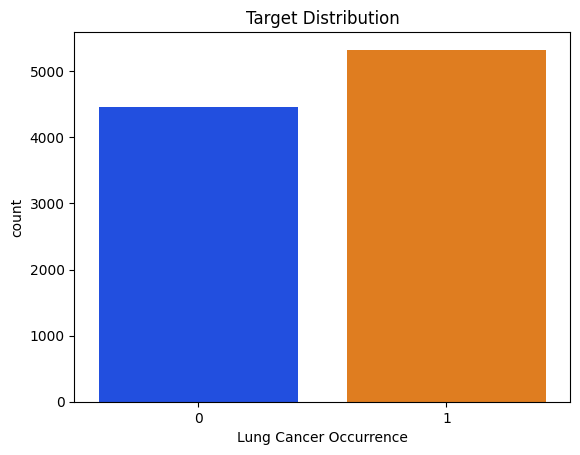

In [128]:
sns.countplot(x='Lung Cancer Occurrence', hue='Lung Cancer Occurrence', data=df, dodge=False, palette='bright', legend=False)
plt.title('Target Distribution');

In [129]:
# function for plotting
def plot(col, df=df):
    return df.groupby(col)['Lung Cancer Occurrence'].value_counts(normalize=True).unstack().plot(kind='bar', figsize=(8,5))

<Axes: xlabel='COPD History'>

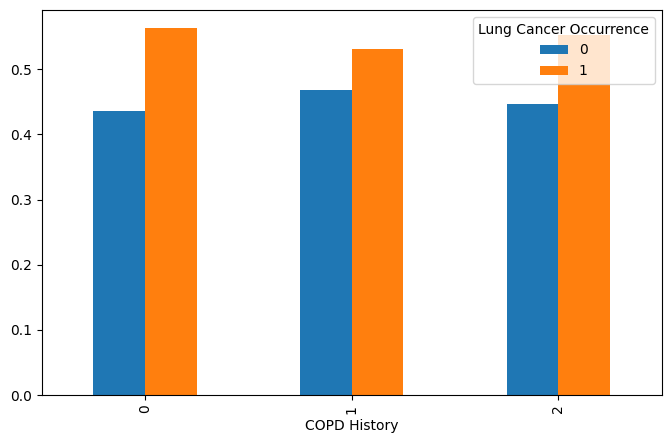

In [130]:
plot('COPD History')

<Axes: xlabel='Genetic Markers'>

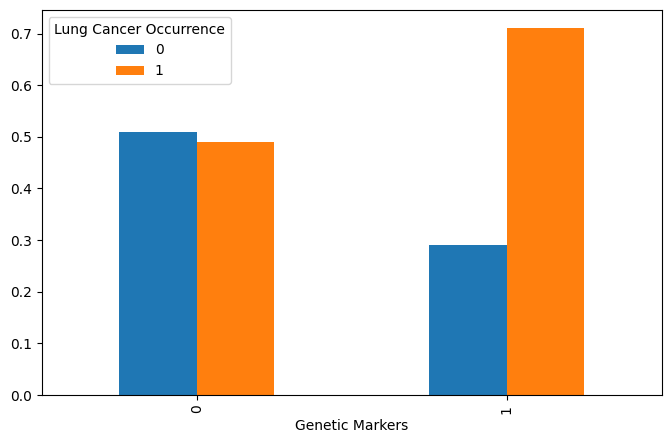

In [131]:
plot('Genetic Markers')

<Axes: xlabel='Taken Bronchodilators'>

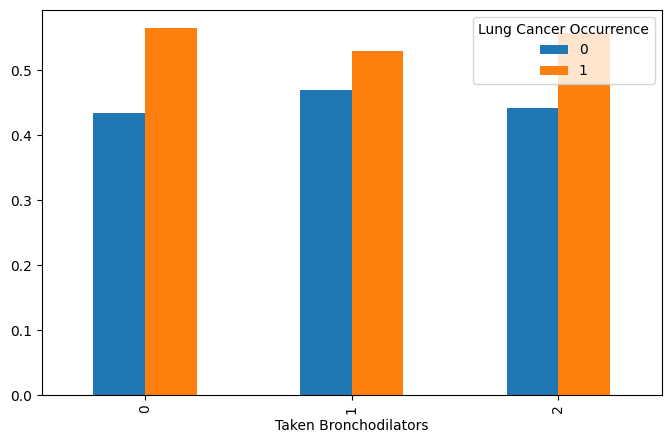

In [132]:
plot('Taken Bronchodilators')

In [133]:
# Define bins as per your requirement
bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

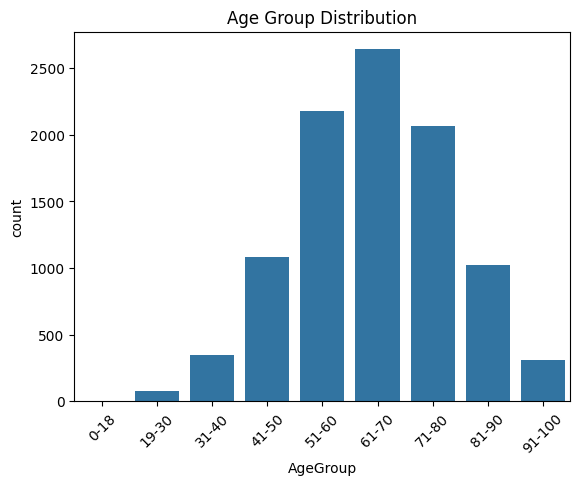

In [134]:
sns.countplot(x='AgeGroup', data=df)
plt.title('Age Group Distribution')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()


In [135]:
#None/Low = 0
#Medium =1
#High = 2

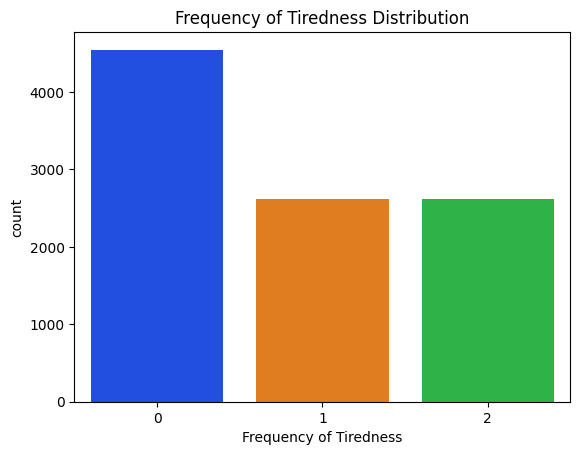

In [136]:
#Let's check the distributaion of Target variable.
color_dict = {
    '0': 'blue', 
    '1': 'green', 
    '2': 'yellow'}
sns.countplot(x='Frequency of Tiredness', hue='Frequency of Tiredness', data=df, dodge=False, palette='bright', legend=False)
plt.title('Frequency of Tiredness Distribution');

In [137]:
#Low = 0
#Medium =1
#High = 2

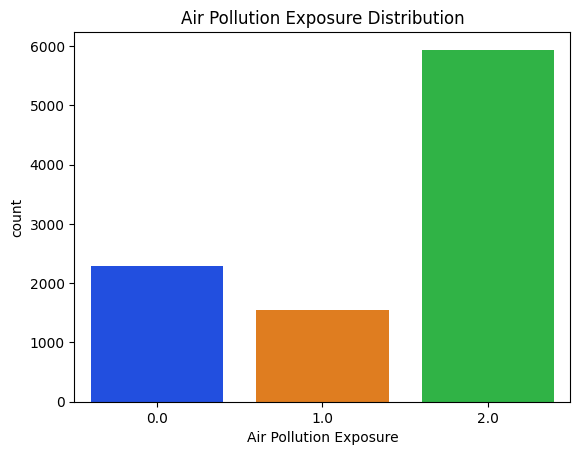

In [138]:
#Let's check the distributaion of Target variable.
sns.countplot(x='Air Pollution Exposure', hue='Air Pollution Exposure', data=df, dodge=False, palette='bright', legend=False)
plt.title('Air Pollution Exposure Distribution');

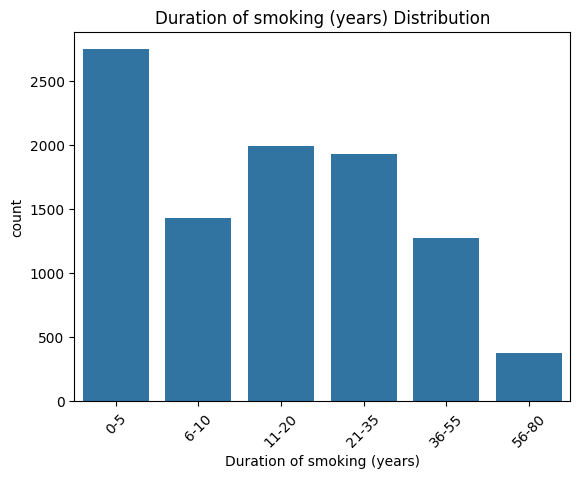

In [139]:
# Define bins as per your requirement
bins = [0,5,10,20,35,55,80]
labels = ['0-5', '6-10', '11-20', '21-35', '36-55', '56-80']
df['Duration of smoking (years)'] = pd.cut(df['Duration of smoking (years)'], bins=bins, labels=labels, right=False)

sns.countplot(x='Duration of smoking (years)', data=df)
plt.title('Duration of smoking (years) Distribution')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()


In [140]:
def range_to_midpoint(range_str):
    low, high = map(int, range_str.split('-'))
    return (low + high) / 2

df['Duration of smoking (Midpoint in years)'] = df['Duration of smoking (years)'].apply(range_to_midpoint)

print(df)

                ID  Age  Gender  COPD History  Genetic Markers  \
0     1.468154e+16   42       0             0                0   
1     1.271684e+18   72       0             1                0   
2     1.708068e+18   65       0             1                0   
3     3.555829e+17   67       0             0                0   
4     1.684598e+18   54       0             1                0   
...            ...  ...     ...           ...              ...   
9993  1.990595e+17   59       0             1                1   
9994  1.571559e+18   76       0             1                1   
9995  1.968467e+18   57       0             1                1   
9996  9.739915e+16   74       0             1                0   
9997  2.105403e+17   61       0             1                0   

      Air Pollution Exposure  Last Weight  Current Weight  Start Smoking  \
0                        1.0           73              69           2015   
1                        2.0           50              

In [141]:
df_new = df.drop(columns=["Start Smoking","Stop Smoking","AgeGroup","Duration of smoking (years)"])

df_new.dropna(subset=['Air Pollution Exposure','Duration of smoking (Midpoint in years)'],inplace=True)

In [142]:
df_new.isnull().sum()

ID                                         0
Age                                        0
Gender                                     0
COPD History                               0
Genetic Markers                            0
Air Pollution Exposure                     0
Last Weight                                0
Current Weight                             0
Taken Bronchodilators                      0
Frequency of Tiredness                     0
Dominant Hand                              0
Lung Cancer Occurrence                     0
Duration of smoking (Midpoint in years)    0
dtype: int64

In [143]:
cn = df_new.corr()
cn

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Duration of smoking (Midpoint in years)
ID,1.000000,-0.011513,NaN,-0.004676,-0.009867,-0.007456,-0.004114,0.000910,0.001359,-0.004154,0.017323,-0.003340,0.006174
Age,-0.011513,1.000000,NaN,-0.139735,0.094359,0.081254,-0.004729,-0.002589,-0.145586,0.137632,0.010991,0.011036,0.095548
Gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COPD History,-0.004676,-0.139735,NaN,1.000000,0.068197,-0.044278,0.010840,0.010804,0.700865,-0.154697,0.007606,-0.017520,-0.022295
Genetic Markers,-0.009867,0.094359,NaN,0.068197,1.000000,-0.178247,0.001158,-0.031690,0.074708,0.093376,0.008905,0.192039,-0.026688
Air Pollution Exposure,-0.007456,0.081254,NaN,-0.044278,-0.178247,1.000000,0.003759,-0.014516,-0.039737,-0.039249,-0.011530,0.118414,0.038875
Last Weight,-0.004114,-0.004729,NaN,0.010840,0.001158,0.003759,1.000000,0.918492,0.016334,0.003251,-0.004232,-0.000106,-0.003839
Current Weight,0.000910,-0.002589,NaN,0.010804,-0.031690,-0.014516,0.918492,1.000000,0.018188,0.008816,-0.000587,-0.157036,0.004070
Taken Bronchodilators,0.001359,-0.145586,NaN,0.700865,0.074708,-0.039737,0.016334,0.018188,1.000000,-0.164843,0.001062,-0.018318,-0.017912
Frequency of Tiredness,-0.004154,0.137632,NaN,-0.154697,0.093376,-0.039249,0.003251,0.008816,-0.164843,1.000000,0.009009,-0.017709,0.028065


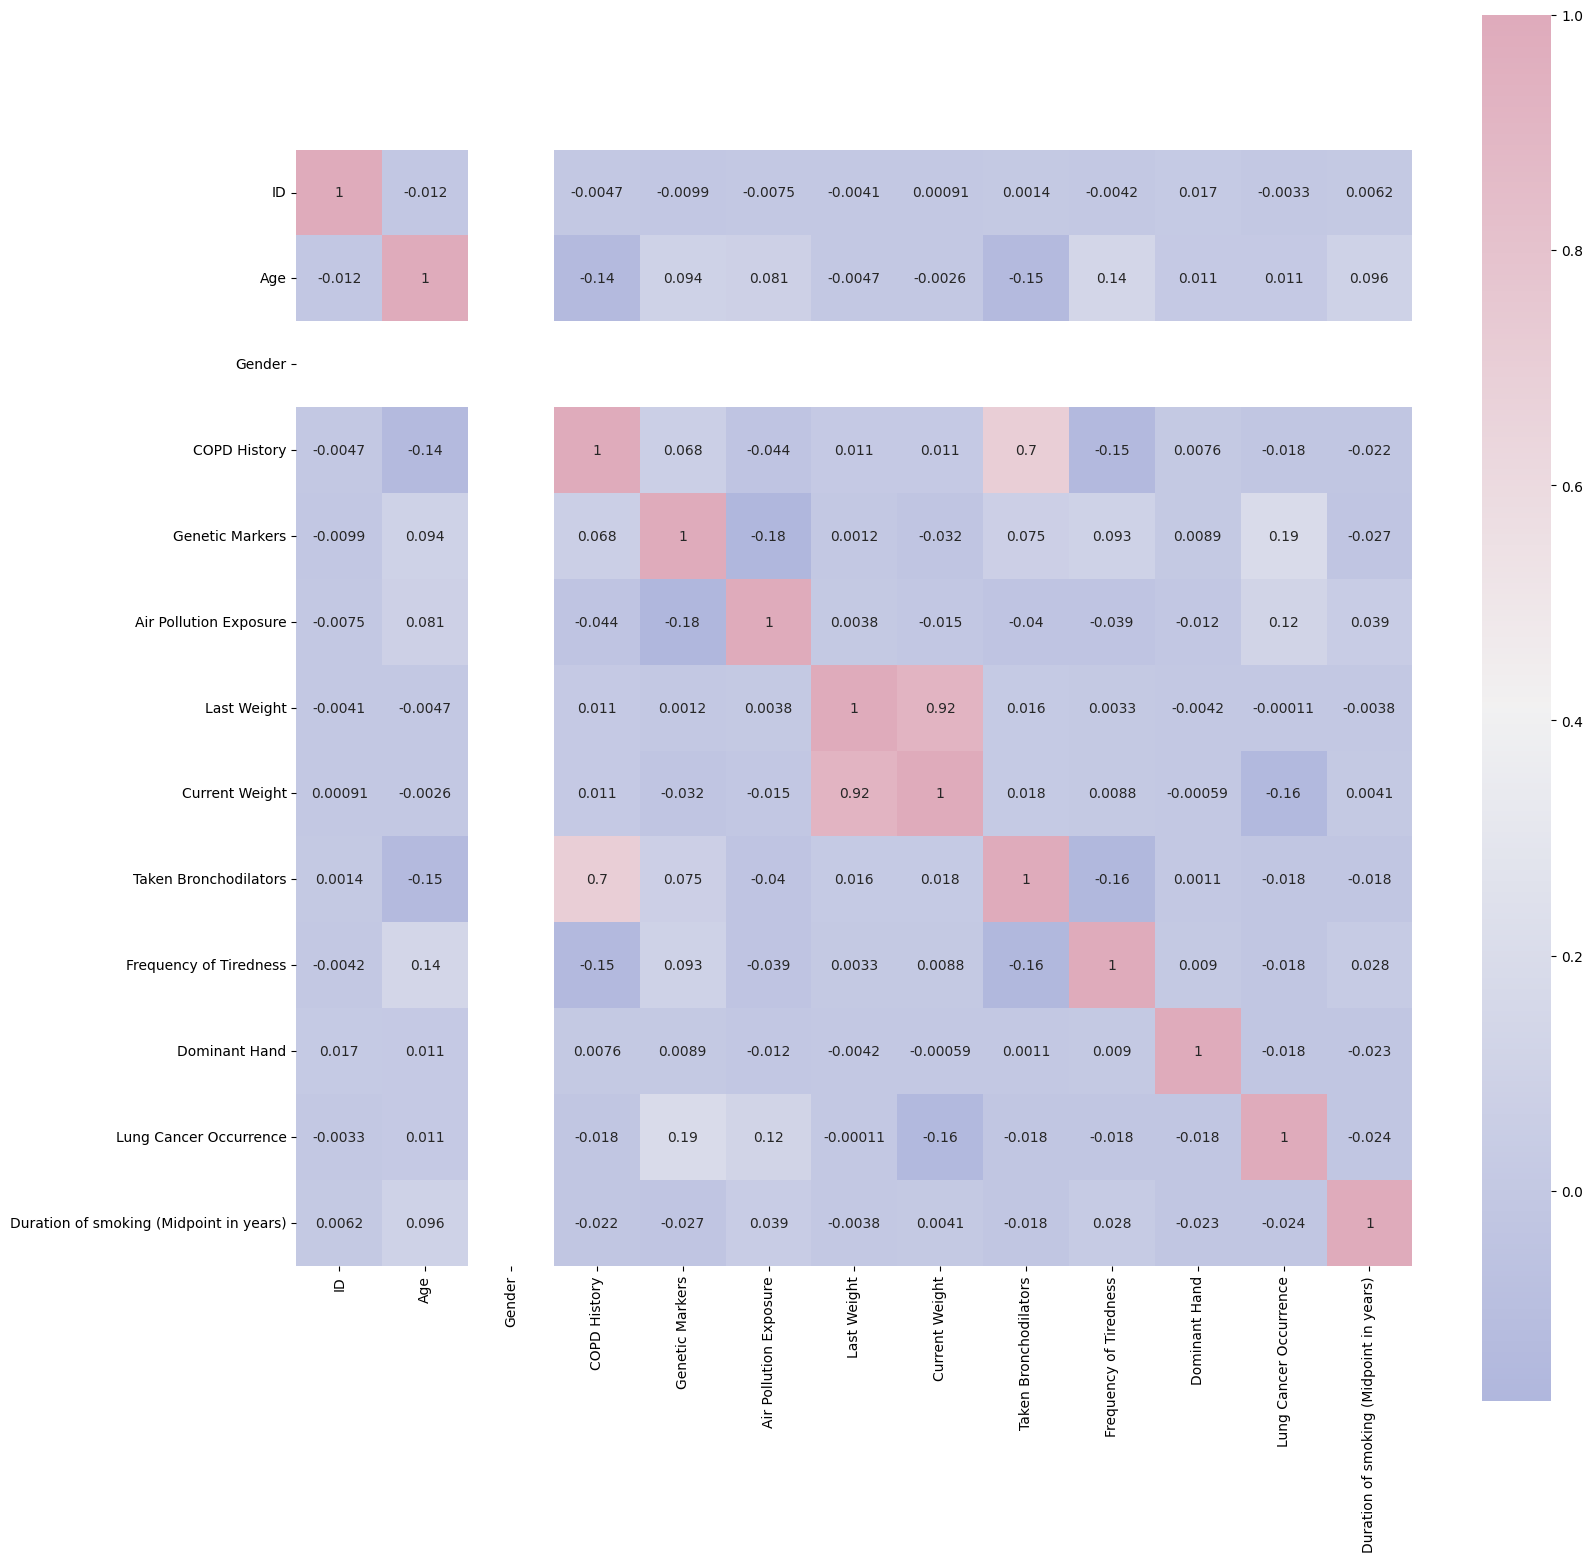

In [144]:
#Correlation 
cmap=sns.diverging_palette(260,-10,s=50, l=75, n=6,
as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(cn,cmap=cmap,annot=True, square=True)
plt.show()

FEATURE ENGINEERING

Feature Engineering is the process of creating new features using existing features.
The correlation matrix shows that 'Taken Bronchodilators' and 'COPD History' are correlated more than 50%. So, lets create a new feature combining them.

In [145]:
df_new['COPDBRONCHO']=df_new['Taken Bronchodilators']*df_new['COPD History']
df_new

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence,Duration of smoking (Midpoint in years),COPDBRONCHO
0,1.468154e+16,42,0,0,0,1.0,73,69,0,0,1,1,8.0,0
1,1.271684e+18,72,0,1,0,2.0,50,42,1,1,1,1,8.0,1
2,1.708068e+18,65,0,1,0,0.0,65,75,1,0,1,0,28.0,1
3,3.555829e+17,67,0,0,0,2.0,69,58,0,0,1,1,2.5,0
4,1.684598e+18,54,0,1,0,1.0,46,40,1,0,1,0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,1.990595e+17,59,0,1,1,1.0,56,46,1,0,0,1,15.5,1
9994,1.571559e+18,76,0,1,1,2.0,90,78,1,2,1,1,28.0,1
9995,1.968467e+18,57,0,1,1,2.0,63,62,1,2,1,1,15.5,1
9996,9.739915e+16,74,0,1,0,2.0,87,77,1,0,2,0,2.5,1


In [146]:
#Splitting independent and dependent variables
X = df_new.drop(columns=["Lung Cancer Occurrence"], axis = 1)
y = df_new['Lung Cancer Occurrence']

In [147]:
X

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Duration of smoking (Midpoint in years),COPDBRONCHO
0,1.468154e+16,42,0,0,0,1.0,73,69,0,0,1,8.0,0
1,1.271684e+18,72,0,1,0,2.0,50,42,1,1,1,8.0,1
2,1.708068e+18,65,0,1,0,0.0,65,75,1,0,1,28.0,1
3,3.555829e+17,67,0,0,0,2.0,69,58,0,0,1,2.5,0
4,1.684598e+18,54,0,1,0,1.0,46,40,1,0,1,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,1.990595e+17,59,0,1,1,1.0,56,46,1,0,0,15.5,1
9994,1.571559e+18,76,0,1,1,2.0,90,78,1,2,1,28.0,1
9995,1.968467e+18,57,0,1,1,2.0,63,62,1,2,1,15.5,1
9996,9.739915e+16,74,0,1,0,2.0,87,77,1,0,2,2.5,1


In [148]:
X.isnull().sum()


ID                                         0
Age                                        0
Gender                                     0
COPD History                               0
Genetic Markers                            0
Air Pollution Exposure                     0
Last Weight                                0
Current Weight                             0
Taken Bronchodilators                      0
Frequency of Tiredness                     0
Dominant Hand                              0
Duration of smoking (Midpoint in years)    0
COPDBRONCHO                                0
dtype: int64

In [149]:
print(pd.Series(y).value_counts())


Lung Cancer Occurrence
1    5316
0    4436
Name: count, dtype: int64


Target Distribution Imbalance Handling

In [150]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

LOGISTIC REGRESSION

In [151]:
#Splitting data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, random_state=0)

In [152]:
#Fitting training data to the model
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [153]:
#Predicting result using testing data
y_lr_pred= lr_model.predict(X_test)
y_lr_pred

array([1, 1, 1, ..., 1, 1, 1])

In [154]:
#Model accuracy
from sklearn.metrics import classification_report, accuracy_score, f1_score
lr_cr=classification_report(y_test, y_lr_pred)
print(lr_cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1132
           1       0.54      1.00      0.70      1306

    accuracy                           0.54      2438
   macro avg       0.27      0.50      0.35      2438
weighted avg       0.29      0.54      0.37      2438



/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DECISION TREE

In [155]:
#Fitting training data to the model
from sklearn.tree import DecisionTreeClassifier
dt_model= DecisionTreeClassifier(criterion='entropy', random_state=0)  
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [156]:
#Predicting result using testing data
y_dt_pred= dt_model.predict(X_test)
y_dt_pred

array([0, 1, 0, ..., 1, 0, 0])

In [157]:
#Model accuracy
dt_cr=classification_report(y_test, y_dt_pred)
print(dt_cr)


              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1132
           1       0.64      0.64      0.64      1306

    accuracy                           0.62      2438
   macro avg       0.62      0.62      0.62      2438
weighted avg       0.62      0.62      0.62      2438



K NEAREST NEIGHBOUR

In [158]:
#Fitting K-NN classifier to the training set  
from sklearn.neighbors import KNeighborsClassifier  
knn_model= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [159]:
#Predicting result using testing data
y_knn_pred= knn_model.predict(X_test)
y_knn_pred

array([0, 0, 1, ..., 1, 0, 0])

In [160]:
#Model accuracy
knn_cr=classification_report(y_test, y_knn_pred)
print(knn_cr)

              precision    recall  f1-score   support

           0       0.46      0.43      0.44      1132
           1       0.53      0.56      0.54      1306

    accuracy                           0.50      2438
   macro avg       0.49      0.49      0.49      2438
weighted avg       0.49      0.50      0.50      2438



Gaussian Naive Bayes

In [161]:
#Fitting Gaussian Naive Bayes classifier to the training set  
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

GaussianNB()

In [162]:
#Predicting result using testing data
y_gnb_pred= gnb_model.predict(X_test)
y_gnb_pred

array([1, 1, 1, ..., 1, 1, 1])

In [163]:
#Model accuracy
gnb_cr=classification_report(y_test, y_gnb_pred)
print(gnb_cr)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1132
           1       0.54      1.00      0.70      1306

    accuracy                           0.54      2438
   macro avg       0.27      0.50      0.35      2438
weighted avg       0.29      0.54      0.37      2438



/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Classifier


In [164]:
#Fitting SVC to the training set  
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, y_train)

SVC()

In [165]:
#Predicting result using testing data
y_svc_pred= svc_model.predict(X_test)
y_svc_pred

array([1, 1, 1, ..., 1, 1, 1])

In [166]:
#Model accuracy
svc_cr=classification_report(y_test, y_svc_pred)
print(svc_cr)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1132
           1       0.54      1.00      0.70      1306

    accuracy                           0.54      2438
   macro avg       0.27      0.50      0.35      2438
weighted avg       0.29      0.54      0.37      2438



/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RANDOM FOREST

In [167]:
#Training
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [168]:
#Predicting result using testing data
y_rf_pred= rf_model.predict(X_test)
y_rf_pred

array([0, 1, 1, ..., 0, 1, 1])

In [169]:
#Model accuracy
rf_cr=classification_report(y_test, y_rf_pred)
print(rf_cr)

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      1132
           1       0.68      0.74      0.71      1306

    accuracy                           0.68      2438
   macro avg       0.67      0.67      0.67      2438
weighted avg       0.68      0.68      0.67      2438



Multi-layer Perceptron classifier

In [170]:
#Training a neural network model
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier()
mlp_model.fit(X_train, y_train)

MLPClassifier()

In [171]:
#Predicting result using testing data
y_mlp_pred= mlp_model.predict(X_test)
y_mlp_pred

array([0, 0, 0, ..., 0, 0, 0])

In [172]:
#Model accuracy
mlp_cr=classification_report(y_test, y_mlp_pred)
print(mlp_cr)


              precision    recall  f1-score   support

           0       0.46      1.00      0.63      1132
           1       0.00      0.00      0.00      1306

    accuracy                           0.46      2438
   macro avg       0.23      0.50      0.32      2438
weighted avg       0.22      0.46      0.29      2438



/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Gradient Boosting

In [173]:
#Training
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [174]:
#Predicting result using testing data
y_gb_pred= gb_model.predict(X_test)
y_gb_pred

array([0, 0, 0, ..., 0, 1, 1])

In [175]:
#Model accuracy
gb_cr=classification_report(y_test, y_gb_pred)
print(gb_cr)

              precision    recall  f1-score   support

           0       0.71      0.54      0.62      1132
           1       0.67      0.81      0.73      1306

    accuracy                           0.69      2438
   macro avg       0.69      0.68      0.67      2438
weighted avg       0.69      0.69      0.68      2438



From the above calculated accuracies, it is clear that the Random Forest AND Gradient Boosting models performed better. However, I'm interested in a more efficient way of evaluating these models. Let's go for the Cross Validation methods using both K-Fold and Stratified K-Fold.

CROSS VALIDATION

K-Fold cross validation is a popular technique used in machine learning for model evaluation and selection. It involves dividing a dataset into K subsets of equal size, called folds. The algorithm then trains and evaluates the model K times, each time using a different fold as the validation set and the remaining K-1 folds as the training set.

During each iteration of K-Fold cross validation, the model is trained on K-1 folds and evaluated on the remaining fold. The performance metrics are then averaged over all K iterations to obtain an estimate of the model's overall performance.

K-Fold cross validation is a robust method for model evaluation because it uses all the available data for training and testing. It also helps to reduce the risk of overfitting and provides a more accurate estimate of the model's performance than using a single training-test split.

Typically, values of K between 5 and 10 are used for K-Fold cross validation, but the optimal value of K may vary depending on the size and complexity of the dataset, as well as the type of model being evaluated.

Here are some general guidelines that can help you choose an appropriate value of K:

For small datasets, it is recommended to use a larger value of K, such as 10. This is because the larger value of K allows for more robust estimates of model performance, given the limited amount of data.

For larger datasets, a smaller value of K can be used, such as 5. This is because a larger value of K will result in K smaller training sets, which may not be representative of the full dataset. Using a smaller value of K ensures that each fold has a sufficient amount of data for both training and testing.

For models that are computationally expensive or time-consuming to train, a smaller value of K is preferred to reduce the overall training time.

It's also essential to note that the choice of K should not be based solely on the accuracy of the model. Other metrics, such as precision, recall, and F1 score, should also be considered, as they can provide valuable insights into the performance of the model.

In [177]:
# K-Fold Cross Validation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)


# Logistic regression model
lr_model_scores = cross_val_score(lr_model,X, y, cv=kf)

# Decision tree model
dt_model_scores = cross_val_score(dt_model,X, y, cv=kf)

# KNN model
knn_model_scores = cross_val_score(knn_model,X, y, cv=kf)

# Gaussian naive bayes model
gnb_model_scores = cross_val_score(gnb_model,X, y, cv=kf)

# Support Vector Classifier model
svc_model_scores = cross_val_score(svc_model,X, y, cv=kf)

# Random forest model
rf_model_scores = cross_val_score(rf_model,X, y, cv=kf)

# Gradient boost model
gb_model_scores = cross_val_score(gb_model,X, y, cv=kf)

print("Logistic regression models' average accuracy:", np.mean(lr_model_scores))
print("Decision tree models' average accuracy:", np.mean(dt_model_scores))
print("KNN models' average accuracy:", np.mean(knn_model_scores))
print("Gaussian naive bayes models' average accuracy:", np.mean(gnb_model_scores))
print("Support Vector Classifier models' average accuracy:", np.mean(svc_model_scores))
print("Random forest models' average accuracy:", np.mean(rf_model_scores))
print("Gradient boost models' average accuracy:", np.mean(gb_model_scores))



Logistic regression models' average accuracy: 0.5451195836454679
Decision tree models' average accuracy: 0.6298196585577417
KNN models' average accuracy: 0.5040008936902838
Gaussian naive bayes models' average accuracy: 0.5451195836454679
Support Vector Classifier models' average accuracy: 0.5451195836454679
Random forest models' average accuracy: 0.6685800049941516
Gradient boost models' average accuracy: 0.6896044369094086


Stratified K-Fold cross-validation is a modification of the standard K-Fold cross-validation technique that is commonly used in machine learning when working with imbalanced datasets. The goal of Stratified K-Fold cross-validation is to ensure that each fold is representative of the overall dataset in terms of the class distribution.

In standard K-Fold cross-validation, the data is split into K folds, and each fold is used as the validation set in turn. However, if the dataset has an imbalanced class distribution, this can lead to some of the folds having significantly fewer samples from the minority class, which can result in biased performance estimates.

To address this issue, Stratified K-Fold cross-validation ensures that each fold has a similar proportion of samples from each class. It works by first dividing the dataset into K folds, as in standard K-Fold cross-validation. Then, for each fold, the algorithm ensures that the proportion of samples from each class is roughly the same as the proportion in the full dataset. This ensures that the model is evaluated on a representative sample of the data, regardless of the class distribution.

Stratified K-Fold cross-validation is a powerful tool for evaluating the performance of machine learning models on imbalanced datasets. It can help to ensure that the model's performance is accurately estimated and that the model is robust to class imbalances in the dataset.

In [ ]:
# K-Fold Cross Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = StratifiedKFold(n_splits=k)

# Logistic regression model
lr_model_scores = cross_val_score(lr_model,X, y, cv=kf)

# Decision tree model
dt_model_scores = cross_val_score(dt_model,X, y, cv=kf)

# KNN model
knn_model_scores = cross_val_score(knn_model,X, y, cv=kf)

# Gaussian naive bayes model
gnb_model_scores = cross_val_score(gnb_model,X, y, cv=kf)

# Support Vector Classifier model
svc_model_scores = cross_val_score(svc_model,X, y, cv=kf)

# Random forest model
rf_model_scores = cross_val_score(rf_model,X, y, cv=kf)




print("Logistic regression models' average accuracy:", np.mean(lr_model_scores))
print("Decision tree models' average accuracy:", np.mean(dt_model_scores))
print("KNN models' average accuracy:", np.mean(knn_model_scores))
print("Gaussian naive bayes models' average accuracy:", np.mean(gnb_model_scores))
print("Support Vector Classifier models' average accuracy:", np.mean(svc_model_scores))
print("Random forest models' average accuracy:", np.mean(rf_model_scores))
